In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# use directories as per your convinence

ear_detect = '/content/drive/My Drive/ear_detect'

In [2]:
import cv2
import dlib
from imutils import face_utils, resize
import numpy as np
import math
import matplotlib.pyplot as plt

# pretrained models for face points detection
model_path = '/content/drive/My Drive/ear_detect/shape_predictor_68_face_landmarks.dat'
cascadePath = "/content/drive/My Drive/ear_detect/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)

def get_head_mask(img):
    """
    Find face in pic and remove background
    :param img:
    :return:
    """
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))    # Find faces
    if len(faces) != 0:
        x, y, w, h = faces[0]
        (x, y, w, h) = (x - 40, y - 100, w + 80, h + 200)
        rect1 = (x, y, w, h)
        cv2.grabCut(img, mask, rect1, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)     #Crop BG around the head
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')  # Take the mask from BG
    return mask2

#############################
file_name="/content/drive/My Drive/ear_detect/img/1.jpg"

img1 = cv2.imread(file_name)     # Load image
img1 = resize(img1, height=500)  # We result in 500px in height
mask = get_head_mask(img1) 




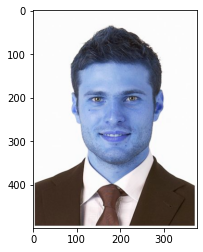

In [3]:
plt.imshow(img1)
plt.show()

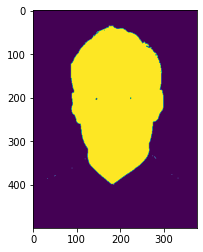

In [4]:
plt.imshow(mask)
plt.show()

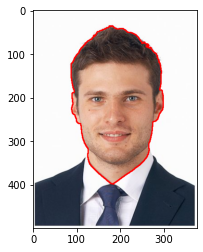

In [5]:
# Find the contours, take the largest one and memorize its upper point as the top of the head
cnts = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[0]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# Plot head contours
cv2.drawContours(img1, [cnts[0]], -1, (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

LEFT EAR POINT WAS DETECTED
RIGHT EAR POINT WAS DETECTED


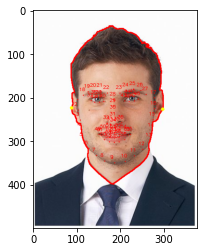

In [6]:
# Find main facial keypoints
face_detector = dlib.get_frontal_face_detector()
facial_landmark_predictor = dlib.shape_predictor(model_path)

# convert to grayscale
grayImage = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
faces = face_detector(grayImage, 1)

# for all faces detect facial keypoints (if on pic will be one person - use without loop)
for (i, face) in enumerate(faces):

    facial_landmarks = facial_landmark_predictor(grayImage, face)
    facial_landmarks = face_utils.shape_to_np(facial_landmarks)

    # plot facial keypoints if needed
    for (i, (x, y)) in enumerate(facial_landmarks):
        cv2.circle(img1, (x, y), 1, (0, 0, 255), -1)
        cv2.putText(img1, str(i + 1), (x - 10, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)

# find left ear:

left_x_1 = int((facial_landmarks[0][0] + facial_landmarks[1][0]) / 2)
left_y_1 = int((facial_landmarks[0][1] + facial_landmarks[1][1]) / 2)

range_face = facial_landmarks[15][0] - facial_landmarks[2][0]

min_index = None
min_dist = 10000000
ear_point_x, ear_point_y = facial_landmarks[1][0], facial_landmarks[1][1]

for idx, ex in enumerate(cnts[0]):
    x, y = ex[0][0], ex[0][1]
    distance = math.sqrt((x - ear_point_x) ** 2 + (y - ear_point_y) ** 2)
    if ((distance < min_dist) and \
            ((x - facial_landmarks[1][0]) < 0) and\
            (np.abs(x - facial_landmarks[1][0]) > int(range_face*0.04)) and \
            (np.abs(x - facial_landmarks[1][0]) < int(range_face * 0.15)) and \
            (y < left_y_1 ) and \
            (y > facial_landmarks[36][1] )):
        min_dist = distance
        min_index = idx + 5

possible_left_ear_x = None
possible_left_ear_y = None

possible_right_ear_x = None
possible_right_ear_y = None

if min_index != None:
    # here i plot yellow point with ear (e_x, e_y - coordinates)
    e_x, e_y = cnts[0][min_index][0][0], cnts[0][min_index][0][1]
    cv2.circle(img1, (e_x, e_y), 4, (0, 255, 255), -1)
    print('LEFT EAR POINT WAS DETECTED')
else:
    # here condition if ear not founded, but person have hairs. here we create alert with possible location of ear
    for idx, ex in enumerate(cnts[0]):
        x, y = ex[0][0], ex[0][1]
        distance = math.sqrt((x - ear_point_x) ** 2 + (y - ear_point_y) ** 2)

        if ((x - facial_landmarks[1][0]) < 0) and \
                (np.abs(x - facial_landmarks[1][0]) > int(range_face * 0.1)):
            possible_left_ear_x = left_x_1 - 12
            possible_left_ear_y = left_y_1
            break

    print('LEFT EAR WAS NOT FOUND')

#################################################
right_x_1 = int((facial_landmarks[15][0] + facial_landmarks[16][0]) / 2)
right_y_1 = int((facial_landmarks[15][1] + facial_landmarks[16][1]) / 2)

min_index = None
min_dist = 10000000
ear_point_x, ear_point_y = facial_landmarks[1][0], facial_landmarks[1][1]

for idx, ex in enumerate(cnts[0]):
    x, y = ex[0][0], ex[0][1]
    distance = math.sqrt((x - ear_point_x) ** 2 + (y - ear_point_y) ** 2)
    if ((distance < min_dist) and \
            ((facial_landmarks[16][0] -x) < 0) and\
            (np.abs(facial_landmarks[16][0] -x) > int(range_face*0.03)) and \
            (np.abs(facial_landmarks[16][0] -x) < int(range_face * 0.15)) and \
            (y < right_y_1 ) and
            (y > facial_landmarks[26][1] )):
        min_dist = distance
        min_index = idx - 4

if min_index != None:
    # here i plot yellow point with ear (e_x, e_y - coordinates)
    e_x, e_y = cnts[0][min_index][0][0], cnts[0][min_index][0][1]
    cv2.circle(img1, (e_x, e_y), 4, (0, 255, 255), -1)
    print('RIGHT EAR POINT WAS DETECTED')
else:
    # here condition if ear not founded, but person have hairs. here we create alert with possible location of ear
    for idx, ex in enumerate(cnts[0]):
        x, y = ex[0][0], ex[0][1]
        distance = math.sqrt((x - ear_point_x) ** 2 + (y - ear_point_y) ** 2)

        if ((facial_landmarks[16][0] -x) < 0) \
                and (np.abs(facial_landmarks[16][0] -x) > int(range_face * 0.1)):
            possible_right_ear_x = right_x_1 + 12
            possible_right_ear_y = right_y_1
            break
    print('RIGHT EAR WAS NOT FOUND')

if possible_right_ear_x !=None and possible_left_ear_x !=None:
    print('MB THIS IS A GIRL WITH HAIR AND EAR POINTS MAY BE HERE')
    cv2.circle(img1, (possible_right_ear_x, possible_right_ear_y), 4, (0, 255, 255), -1)
    cv2.circle(img1, (possible_left_ear_x, possible_left_ear_y), 4, (0, 255, 255), -1)


plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

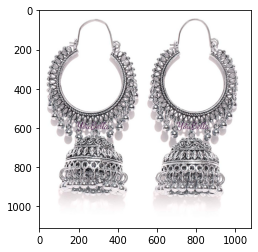

In [7]:
earring_path = '/content/drive/My Drive/ear_detect/img/earring1.jpg'
earring = cv2.imread(earring_path,1)
plt.imshow(earring)
plt.show()

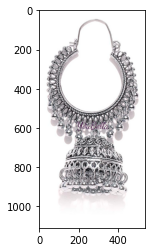

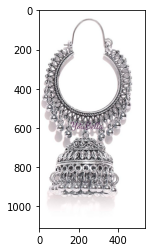

In [8]:
# for dividing earring image in half 

roi1 = earring[0:int(earring.shape[0]),0:int(earring.shape[1]/2)]
roi2 = earring[0:int(earring.shape[0]),int(earring.shape[1]/2):earring.shape[1]]
plt.imshow(roi1)
plt.show()
plt.imshow(roi2)
plt.show()

In [59]:
# we can use either 14/15 and 2/3 points for earring placement
facial_landmarks[15]
x_15 = facial_landmarks[14][0]
y_15 = facial_landmarks[14][1]

In [53]:
facial_landmarks[13]
x_13 = facial_landmarks[13][0]
y_13 = facial_landmarks[13][1]

facial_landmarks[3]
x_1 = facial_landmarks[2][0]
y_1 = facial_landmarks[2][1]

In [11]:
distance_14_15 = math.sqrt((x_15 - x_13) ** 2 + (y_15 - y_13) ** 2)

In [70]:
d_14_15=int(distance_14_15)
d_14_15_2 = int(d_14_15/2)

In [71]:
roi1_2 = cv2.resize(roi1,(d_14_15_2,d_14_15))

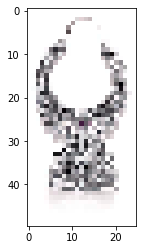

In [72]:
plt.imshow(roi1_2)

In [73]:
img1.shape

(500, 376, 3)

In [74]:
img2  = img1.copy()

In [75]:

#for making earing image transparent and placing on face

burger_copy = roi1_2.copy()
template_copy = img2.copy()


roi_face1 = template_copy[y_15:y_15+d_14_15,x_15:x_15+d_14_15_2]
roi_face2 = template_copy[y_1:y_1+d_14_15,x_1-d_14_15_2:x_1]

img3 = burger_copy
rows,cols,channel=img3.shape
#gets the reigon of image of img1 with the size of img3
img3gray=cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY) #converts color to gray
ret,mask=cv2.threshold(src=img3gray,thresh=240,maxval=255,type=cv2.THRESH_BINARY_INV)

mask_inv=cv2.bitwise_not(mask) # gets the inverse of mask

img1_bg=cv2.bitwise_and(roi_face1,roi_face1,mask=mask_inv)
img2_bg=cv2.bitwise_and(roi_face2,roi_face2,mask=mask_inv) # put mask_inv on roi of img1
img3_fg=cv2.bitwise_and(img3,img3,mask=mask)#creates colored area of original image with black/transparent background i think so

dst1=cv2.add(img1_bg,img3_fg) #add both image making only colored area visible

dst2=cv2.add(img2_bg,img3_fg) #add both image making only colored area visible

img_new=template_copy
img_new[y_15:y_15+d_14_15,x_15:x_15+d_14_15_2]=dst1
img_new[y_1:y_1+d_14_15,x_1-d_14_15_2:x_1]=dst2

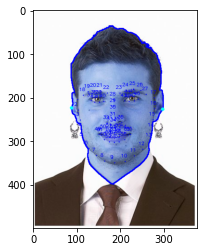

In [76]:
#final image
plt.imshow(img_new)